In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from collections import defaultdict
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100
import matplotlib.pyplot as plt

In [9]:
from models.dataset import DatasetPairs
from models.siamese import SiameseNetwork
from models.contrastive import ContrastiveLoss
from models.trainer import Trainer
from models.visualizer import EmbeddingVisualizer
from models.tester import Tester
from models.noise import LabelNoiseAdder

# Noise Detection

## Prepare

In [10]:
class NoiseDetector:
    def __init__(self, model_class, dataset, device, num_classes=10, model='resnet18', batch_size=256, num_folds=10, model_save_path="model_fold_{}.pth", transform=None, train_pairs=12000, val_pairs=5000):
        self.model_class = model_class
        self.dataset = dataset
        self.device = device
        self.batch_size = batch_size
        self.num_folds = num_folds
        self.model_save_path = model_save_path
        if transform is None:
            self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        else:
            self.transform = transform
        self.models = [self.model_class(num_classes=num_classes, model=model).to(self.device) for _ in range(num_folds)]
        self.kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        self.trainers = []
        self.testers = []
        self.train_pairs = train_pairs
        self.val_pairs = val_pairs

    def train_models(self, num_epochs=10, skip=0):
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(self.dataset)):
            if fold <= (skip - 1):
                continue
            print(f'Training fold {fold + 1}/{self.num_folds}...')
            train_subset = Subset(self.dataset, train_idx)
            val_subset = Subset(self.dataset, val_idx)
            train_loader = DataLoader(DatasetPairs(train_subset, self.train_pairs, self.transform), batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(DatasetPairs(val_subset, self.val_pairs, self.transform), batch_size=8, shuffle=False)

            model = self.model_class().to(self.device)
            optimizer = optim.Adam(model.parameters())
            criterion = nn.CrossEntropyLoss()
            contrastive_criterion = ContrastiveLoss()

            trainer = Trainer(model, contrastive_criterion, criterion, optimizer, train_loader, self.device)

            trainer.train(num_epochs)  # Number of epochs can be adjusted

            visualizer = EmbeddingVisualizer(model, val_loader, self.device)
            embeddings, real_labels, predicted_labels, indices, incorrect_images = visualizer.extract_embeddings()
            visualizer.visualize(embeddings, real_labels, predicted_labels)

            tester = Tester(model, val_loader, self.device)
            tester.test()
            # Save the trained model
            model_save_path = self.model_save_path.format(fold + 1)
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')

            # Deallocate GPU resources by moving the model to CPU
            model.to('cpu')
            torch.cuda.empty_cache()

            print(f'Finished training fold {fold + 1}')

    def get_predictions(self, dataloader):
        all_predictions = defaultdict(list)

        for fold in range(self.num_folds):
            # Reload the model
            model = self.model_class().to(self.device)
            model_save_path = self.model_save_path.format(fold + 1)
            model.load_state_dict(torch.load(model_save_path, map_location=self.device))
            model.eval()

            with torch.no_grad():
                seen_indices = set()
                for img1, img2, label1, label2, i, j in tqdm(dataloader, desc=f"Extracting Predictions for fold {fold + 1}"):
                    img1, img2 = img1.to(self.device), img2.to(self.device)
                    emb1, emb2, class1, class2 = model(img1, img2)
                    outputs1 = nn.functional.softmax(class1, dim=1)
                    outputs2 = nn.functional.softmax(class2, dim=1)
                    
                    for idx, idx_i in enumerate(i):
                        if idx_i.item() not in seen_indices:
                            all_predictions[idx_i.item()].append(outputs1[idx].cpu().numpy())
                            seen_indices.add(idx_i.item())
                    
                    for idx, idx_j in enumerate(j):
                        if idx_j.item() not in seen_indices:
                            all_predictions[idx_j.item()].append(outputs2[idx].cpu().numpy())
                            seen_indices.add(idx_j.item())

        return all_predictions
    
    def evaluate_noisy_samples(self, dataloader):
        wrong_predictions_count = defaultdict(int)

        for fold in range(self.num_folds):
            # Reload the model
            model = self.model_class().to(self.device)
            model_save_path = self.model_save_path.format(fold + 1)
            model.load_state_dict(torch.load(model_save_path, map_location=self.device))
            model.eval()

            with torch.no_grad():
                seen_indices = set()
                for img1, img2, label1, label2, i, j in tqdm(dataloader, desc=f"Evaluating Noisy Samples for fold {fold + 1}"):
                    img1, img2 = img1.to(self.device), img2.to(self.device)
                    emb1, emb2, class1, class2 = model(img1, img2)
                    
                    _, pred1 = torch.max(class1, 1)
                    _, pred2 = torch.max(class2, 1)
                    
                    for idx, idx_i in enumerate(i):
                        if idx_i.item() not in seen_indices:
                            if pred1[idx].item() != label1[idx].item():
                                wrong_predictions_count[idx_i.item()] += 1
                                seen_indices.add(idx_i.item())

                    for idx, idx_j in enumerate(j):
                        if idx_i.item() not in seen_indices:
                            if pred2[idx].item() != label2[idx].item():
                                wrong_predictions_count[idx_j.item()] += 1
                                seen_indices.add(idx_i.item())
                                
            model.to('cpu')
            torch.cuda.empty_cache()

        return wrong_predictions_count

## Fashion MNIST

In [ ]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
test_dataset = FashionMNIST(root='data', train=False, download=False)

train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=10)
train_noise_adder.add_noise()

In [ ]:
test_noise_adder = LabelNoiseAdder(test_dataset, noise_level=0.1, num_classes=10)
test_noise_adder.add_noise()

In [5]:
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_detector = NoiseDetector(SiameseNetwork, train_dataset, device, model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", batch_size=300, transform=transform)

# Train models
# noise_detector.train_models(num_epochs=10)

In [ ]:
# Get predictions for the test data
# test_dataset_pair = FashionMNISTPairs(test_dataset, num_pairs_per_epoch=25000)
# test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)
# test_predictions = noise_detector.get_predictions(test_loader)

In [ ]:
test_dataset_pair = DatasetPairs(test_dataset, num_pairs_per_epoch=25000, transform=transform)
test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)
wrong_preds = noise_detector.evaluate_noisy_samples(test_loader)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sorted_wrong_predictions = sorted(wrong_preds.items(), key=lambda item: item[1], reverse=True)

transform1 = transforms.ToTensor()
transform2 = transforms.ToPILImage()
sorted_indoces = []
plt.figure(figsize=(20, 20))
for i, (idx, count) in enumerate(sorted_wrong_predictions[:50]):
    sorted_indoces.append(idx)
    img, label = test_dataset[idx]
    img = transform2(transform1(img))
    plt.subplot(10, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {class_names[label]} Count: {count}")
    plt.axis('off')
plt.show()


In [ ]:
real_noises = test_noise_adder.get_noisy_indices()

s = [idx for (idx, count) in wrong_preds.items() if count >= 10]
counts = [count for (idx, count) in wrong_preds.items()]

acc = test_noise_adder.calculate_noised_label_percentage(s)

In [ ]:
plt.hist(counts)

## CIFAR10

In [14]:
train_dataset = CIFAR10(root='data', train=True, download=False)
test_dataset = CIFAR10(root='data', train=False, download=False)


In [ ]:

train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=10)
train_noise_adder.add_noise()

test_noise_adder = LabelNoiseAdder(test_dataset, noise_level=0.1, num_classes=10)
test_noise_adder.add_noise()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_detector = NoiseDetector(SiameseNetwork, train_dataset, device, model_save_path="cifar10/resnet18/model_resnet18_cifar10_fold_{}.pth", batch_size=300)
# noise_detector.train_models(num_epochs=40)

In [6]:
train_dataset = CIFAR10(root='data', train=True, download=False)
train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=10)
train_noise_adder.add_noise()
train_dataset_pair = DatasetPairs(train_dataset, num_pairs_per_epoch=25000)
train_loader = DataLoader(train_dataset_pair, batch_size=1024, shuffle=False)
wrong_preds = noise_detector.evaluate_noisy_samples(train_loader)
s = [idx for (idx, count) in wrong_preds.items() if count >= 10]
train_noise_adder.calculate_noised_label_percentage(s)

def remove_noisy_samples(dataset, noisy_indices):
    clean_indices = [i for i in range(len(dataset)) if i not in noisy_indices]
    cleaned_dataset = Subset(dataset, clean_indices)
    return cleaned_dataset

cleaned_train_dataset = remove_noisy_samples(train_dataset, s)

Evaluating Noisy Samples for fold 10: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


98.61495844875347% accuracy in 1805 data


(array([5.182e+03, 3.045e+03, 1.569e+03, 6.420e+02, 1.962e+03, 2.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

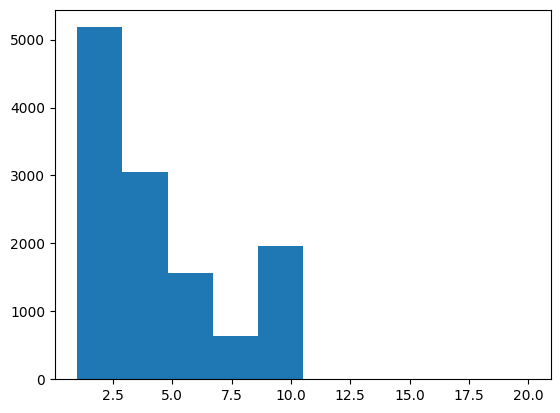

In [10]:
counts = [count for (idx, count) in wrong_preds.items()]
plt.hist(counts)

In [9]:
model.to('cpu')
torch.cuda.empty_cache()

In [16]:
cleaned_train_dataset_pair = DatasetPairs(cleaned_train_dataset, num_pairs_per_epoch=12000)
cleaned_train_loader = DataLoader(cleaned_train_dataset_pair, batch_size=256, shuffle=True)
test_dataset_pair = DatasetPairs(test_dataset, num_pairs_per_epoch=5000)
test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)

Epoch 1/40: 100%|██████████| 47/47 [03:21<00:00,  4.30s/it, loss=4.67]


Epoch 1/40, Loss: 6.319752033720625


Epoch 2/40: 100%|██████████| 47/47 [00:43<00:00,  1.08it/s, loss=4.66]


Epoch 2/40, Loss: 4.692433935530643


Epoch 3/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=4.7] 


Epoch 3/40, Loss: 4.680119747811175


Epoch 4/40: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s, loss=4.6] 


Epoch 4/40, Loss: 4.651308019110497


Epoch 5/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=4.54]


Epoch 5/40, Loss: 4.600371147723908


Epoch 6/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=4.48]


Epoch 6/40, Loss: 4.545338092966283


Epoch 7/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=4.36]


Epoch 7/40, Loss: 4.431450559737835


Epoch 8/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=4.26]


Epoch 8/40, Loss: 4.290683776774305


Epoch 9/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=4.01]


Epoch 9/40, Loss: 4.151550987933544


Epoch 10/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=3.76]


Epoch 10/40, Loss: 3.905747231016768


Epoch 11/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=3.63]


Epoch 11/40, Loss: 3.7314781787547657


Epoch 12/40: 100%|██████████| 47/47 [00:43<00:00,  1.07it/s, loss=3.29]


Epoch 12/40, Loss: 3.436150576205964


Epoch 13/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=3.18]


Epoch 13/40, Loss: 3.2000529918264835


Epoch 14/40: 100%|██████████| 47/47 [00:43<00:00,  1.07it/s, loss=2.92]


Epoch 14/40, Loss: 2.9327898989332484


Epoch 15/40: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s, loss=2.54]


Epoch 15/40, Loss: 2.6650206535420518


Epoch 16/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=2.47]


Epoch 16/40, Loss: 2.4337003028139157


Epoch 17/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=2.28]


Epoch 17/40, Loss: 2.2469702882969633


Epoch 18/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=2.08]


Epoch 18/40, Loss: 1.9828071898602424


Epoch 19/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=1.75]


Epoch 19/40, Loss: 1.8519642302330503


Epoch 20/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=1.71]


Epoch 20/40, Loss: 1.7061290817057833


Epoch 21/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=1.5] 


Epoch 21/40, Loss: 1.5647419158448563


Epoch 22/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=1.37]


Epoch 22/40, Loss: 1.4045518180157275


Epoch 23/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=1.31]


Epoch 23/40, Loss: 1.2742738115026595


Epoch 24/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=1.17]


Epoch 24/40, Loss: 1.2265942477165384


Epoch 25/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=1.14]


Epoch 25/40, Loss: 1.1125061055447192


Epoch 26/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=1.07]


Epoch 26/40, Loss: 1.073952560729169


Epoch 27/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=0.978]


Epoch 27/40, Loss: 0.96505835208487


Epoch 28/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=0.93] 


Epoch 28/40, Loss: 0.9109283406683739


Epoch 29/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=0.845]


Epoch 29/40, Loss: 0.8522870375754985


Epoch 30/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=0.857]


Epoch 30/40, Loss: 0.8139779846718971


Epoch 31/40: 100%|██████████| 47/47 [00:42<00:00,  1.10it/s, loss=0.817]


Epoch 31/40, Loss: 0.7714003590827293


Epoch 32/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=0.752]


Epoch 32/40, Loss: 0.7549634575843811


Epoch 33/40: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, loss=0.749]


Epoch 33/40, Loss: 0.73924513192887


Epoch 34/40: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s, loss=0.751]


Epoch 34/40, Loss: 0.7309605644104329


Epoch 35/40: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s, loss=0.689]


Epoch 35/40, Loss: 0.6849574205723215


Epoch 36/40: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s, loss=0.635]


Epoch 36/40, Loss: 0.6456176549830335


Epoch 37/40: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s, loss=0.645]


Epoch 37/40, Loss: 0.6115048426262876


Epoch 38/40: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s, loss=0.629]


Epoch 38/40, Loss: 0.6290008425712585


Epoch 39/40: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s, loss=0.576]


Epoch 39/40, Loss: 0.5946270011840983


Epoch 40/40: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s, loss=0.571]


Epoch 40/40, Loss: 0.5539351638327253


Extracting Embeddings: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [array([0, 7, 8, ..., 9, 6, 9]), array([5, 8, 9, ..., 7, 8, 0]), array([0, 1, 7, ..., 6, 9, 6]), array([0, 4, 8, ..., 2, 3, 0]), array([6, 0, 1, ..., 0, 9, 8]), array([7, 1, 6, ..., 4, 6, 8]), array([6, 3, 7, ..., 7, 4, 7]), array([2, 4, 9, ..., 4, 7, 1]), array([3, 3, 7, ..., 8, 9, 7]), array([6, 1, 5, ..., 8, 8, 6]), array([0, 4, 7, ..., 8, 0, 2]), array([3, 1, 2, ..., 5, 0, 1]), array([4, 5, 4, ..., 4, 8, 2]), array([1, 3, 9, ..., 0, 0, 8]), array([3, 4, 4, ..., 6, 0, 5]), array([3, 1, 1, ..., 5, 7, 8]), array([2, 4, 4, ..., 4, 0, 7]), array([1, 6, 8, ..., 2, 8, 3]), array([9, 4, 5, ..., 3, 6, 0]), array([8, 1, 5, ..., 3, 6, 4]), array([1, 8, 9, ..., 7, 2, 7]), array([4, 4, 7, ..., 3, 9, 8]), array([8, 6, 5, 6, 6, 6, 7, 2, 6, 2, 2, 1, 9, 6, 4, 6, 1, 2, 1, 9, 0, 8,
       2, 2, 7, 6, 7, 7, 8, 2, 5, 0, 1, 8, 8, 1, 0, 3, 6, 5, 1, 2, 1, 8,
       2, 8, 0, 6, 3, 0, 0, 1, 7, 4, 9, 7, 9, 5, 3, 8, 2, 7, 1, 1, 2, 7,
       7, 1, 8, 3, 5, 2, 0, 6, 9, 4, 7, 4, 6, 2, 0, 0, 8, 2, 6, 6, 7, 4,
       0, 5, 1, 6, 1, 9, 7, 9, 8, 5, 4, 5, 7, 2, 3, 8, 2, 6, 3, 9, 3, 4,
       8, 4, 8, 2, 9, 0, 1, 9, 7, 4, 5, 0, 1, 1, 3, 3, 0, 3, 3, 5, 4, 2,
       4, 1, 3, 2, 7, 4, 0, 3, 0, 7, 8, 6, 8, 0, 9, 4, 6, 6, 8, 5, 0, 5,
       8, 6, 4, 6, 4, 5, 9, 6, 8, 0, 4, 4, 8, 8, 3, 7, 4, 6, 9, 6, 0, 0,
       8, 7, 1, 9, 5, 8, 5, 8, 5, 2, 8, 3, 6, 1, 2, 8, 1, 8, 1, 7, 8, 6,
       0, 6, 4, 5, 4, 6, 9, 7, 6, 2, 7, 0, 7, 8, 6, 9, 1, 6, 8, 7, 0, 1,
       7, 3, 8, 2, 4, 8, 3, 6, 5, 3, 0, 0, 9, 3, 5, 5, 3, 7, 4, 5, 4, 4,
       9, 6, 6, 4, 9, 6, 7, 3, 5, 1, 6, 1, 3, 6, 0, 1, 6, 5, 8, 6, 4, 2,
       2, 5, 5, 4, 6, 4, 3, 0, 1, 8, 7, 5, 7, 7, 7, 6, 5, 3, 6, 7, 9, 1,
       5, 0, 3, 5, 6, 1, 8, 1, 5, 5, 7, 3, 1, 1, 4, 9, 9, 6, 9, 4, 8, 4,
       4, 7, 6, 9, 5, 6, 5, 9, 3, 0, 9, 2, 4, 9, 2, 6, 8, 4, 4, 7, 6, 2,
       6, 0, 1, 8, 4, 0, 2, 8, 4, 3, 8, 4, 7, 6, 6, 7, 1, 1, 2, 6, 8, 5,
       0, 0, 8, 9, 7, 9, 6, 7, 6, 4, 4, 0, 9, 0, 0, 3, 2, 0, 9, 3, 4, 0,
       1, 7, 2, 0, 0, 3, 5, 6, 2, 2, 5, 7, 0, 6, 0, 6, 3, 4, 7, 9, 0, 0,
       7, 2, 8, 0, 0, 6, 6, 8, 0, 4, 4, 3, 0, 4, 5, 1, 1, 6, 3, 6, 4, 4,
       8, 5, 6, 5, 6, 0, 6, 6, 0, 2, 7, 5, 0, 7, 3, 0, 3, 8, 7, 8, 6, 2,
       7, 3, 7, 6, 3, 5, 0, 5, 7, 5, 0, 7, 7, 0, 7, 3, 3, 5, 2, 2, 5, 4,
       4, 3, 0, 0, 6, 7, 4, 0, 7, 7, 2, 7, 8, 6, 5, 9, 2, 2, 4, 0, 5, 6,
       0, 5, 2, 5, 5, 7, 0, 8, 3, 6, 1, 4, 5, 4, 0, 6, 2, 2, 9, 5, 0, 0,
       9, 5, 3, 2, 8, 9, 2, 4, 6, 3, 1, 6, 2, 6, 5, 9, 1, 3, 8, 8, 9, 6,
       9, 3, 4, 9, 3, 8, 8, 4, 1, 5, 5, 0, 9, 0, 9, 6, 0, 4, 8, 6, 4, 6,
       9, 9, 0, 6, 9, 3, 2, 8, 6, 4, 1, 6, 8, 0, 6, 9, 0, 2, 6, 8, 2, 8,
       9, 8, 1, 7, 4, 2, 1, 7, 8, 4, 5, 3, 6, 0, 3, 6, 6, 5, 0, 1, 9, 1,
       2, 1, 3, 7, 0, 0, 6, 2, 8, 5, 7, 5, 8, 5, 3, 2, 0, 1, 2, 3, 3, 8,
       2, 0, 5, 2, 0, 7, 3, 2, 9, 0, 6, 5, 5, 5, 0, 5, 1, 8, 4, 8, 4, 1,
       8, 4, 3, 0, 9, 9, 8, 4, 8, 4, 9, 1, 9, 4, 7, 8, 0, 8, 5, 8, 6, 9,
       0, 5, 1, 5, 9, 0, 3, 1, 0, 7, 4, 9, 1, 9, 2, 0, 2, 4, 6, 5, 8, 3,
       3, 4, 5, 6, 3, 3, 0, 9, 4, 0, 1, 8, 4, 8, 5, 4, 3, 1, 7, 9, 6, 0,
       1, 5, 9, 9, 3, 0, 9, 8, 1, 1, 8, 6, 8, 1, 0, 8, 4, 7, 4, 0, 5, 5,
       8, 9, 2, 0, 2, 4, 4, 4, 8, 1]), array([3, 0, 2, 2, 7, 4, 7, 1, 5, 1, 3, 9, 1, 3, 8, 1, 9, 2, 4, 3, 9, 6,
       9, 5, 1, 7, 0, 2, 1, 2, 6, 1, 5, 3, 8, 4, 2, 0, 9, 7, 7, 3, 2, 3,
       1, 6, 0, 9, 9, 5, 5, 4, 1, 3, 6, 1, 7, 2, 4, 9, 3, 0, 9, 9, 4, 2,
       8, 2, 9, 0, 2, 3, 4, 7, 0, 9, 3, 9, 9, 6, 6, 3, 0, 4, 0, 9, 1, 5,
       0, 1, 9, 4, 1, 6, 8, 7, 4, 2, 4, 0, 5, 2, 4, 7, 8, 0, 6, 6, 3, 4,
       3, 6, 8, 0, 5, 6, 6, 9, 3, 8, 8, 4, 8, 7, 2, 7, 7, 9, 7, 8, 4, 8,
       5, 5, 6, 2, 5, 9, 7, 2, 0, 6, 8, 3, 7, 9, 6, 8, 4, 3, 1, 1, 2, 2,
       1, 9, 6, 9, 3, 7, 4, 3, 9, 2, 8, 3, 8, 0, 3, 6, 5, 9, 8, 4, 1, 9,
       3, 8, 8, 6, 3, 8, 7, 0, 2, 2, 0, 2, 4, 2, 4, 8, 6, 7, 6, 3, 0, 6,
       7, 8, 2, 5, 2, 2, 7, 2, 9, 6, 8, 0, 3, 4, 6, 7, 8, 5, 4, 2, 5, 2,
       2, 7, 7, 3, 6, 5, 0, 3, 9, 3, 3, 2, 8, 5, 3, 5, 5, 4, 2, 3, 9, 2,
       1, 9, 0, 4, 3, 0, 9, 0, 6, 3, 6, 0, 0, 1, 8, 3, 6, 6, 3, 8, 1, 0,
       5, 6, 1, 5, 3, 9, 2, 3, 1, 6, 9, 0, 7, 1, 0, 3, 3, 7, 0, 9, 1, 0,
       2, 9, 3, 4, 1, 9, 3, 7, 7, 7, 1, 7, 8, 8, 7, 6, 2, 2, 7, 7, 9, 2,
       8, 4, 3, 1, 4, 9, 1, 4, 3, 0, 1, 4, 4, 0, 3, 0, 5, 8, 8, 0, 4, 2,
       0, 8, 7, 6, 1, 8, 5, 7, 8, 1, 3, 9, 4, 3, 6, 6, 3, 0, 2, 0, 7, 5,
       1, 1, 8, 9, 9, 1, 6, 6, 8, 7, 4, 1, 3, 9, 3, 0, 0, 3, 9, 8, 3, 9,
       3, 4, 2, 9, 3, 8, 0, 8, 9, 7, 8, 1, 6, 7, 7, 1, 7, 9, 3, 5, 2, 9,
       0, 9, 4, 2, 4, 1, 3, 4, 7, 7, 5, 9, 7, 7, 1, 8, 9, 2, 6, 3, 6, 0,
       5, 2, 3, 9, 8, 3, 2, 5, 6, 1, 4, 6, 1, 3, 7, 2, 0, 4, 4, 1, 4, 6,
       6, 3, 4, 5, 4, 1, 5, 9, 0, 2, 4, 7, 4, 3, 5, 9, 7, 5, 3, 3, 0, 3,
       8, 9, 7, 4, 5, 1, 8, 2, 9, 1, 1, 3, 3, 2, 0, 3, 2, 2, 3, 9, 6, 6,
       9, 2, 5, 8, 7, 3, 6, 9, 3, 3, 2, 8, 5, 4, 7, 7, 2, 8, 2, 7, 8, 8,
       7, 3, 4, 3, 2, 7, 8, 0, 1, 3, 2, 6, 1, 7, 0, 4, 4, 0, 6, 4, 9, 0,
       8, 9, 8, 5, 0, 9, 2, 2, 5, 7, 9, 8, 0, 6, 8, 3, 6, 5, 0, 8, 0, 8,
       3, 6, 4, 9, 7, 3, 6, 4, 9, 3, 0, 1, 4, 3, 6, 5, 3, 3, 6, 6, 3, 6,
       1, 8, 1, 8, 3, 9, 8, 3, 3, 1, 6, 3, 6, 0, 4, 6, 7, 2, 3, 8, 9, 4,
       9, 5, 8, 5, 2, 7, 0, 1, 3, 3, 6, 0, 6, 5, 7, 4, 0, 9, 8, 7, 6, 7,
       6, 6, 5, 1, 5, 6, 0, 3, 7, 3, 2, 6, 7, 6, 9, 3, 4, 8, 6, 1, 7, 7,
       0, 2, 9, 6, 7, 0, 9, 1, 1, 4, 7, 8, 8, 4, 6, 4, 8, 0, 6, 8, 0, 5,
       5, 5, 9, 7, 9, 4, 9, 3, 2, 0, 3, 0, 8, 6, 3, 3, 8, 1, 3, 0, 0, 7,
       0, 4, 5, 6, 2, 1, 5, 2, 0, 0, 6, 1, 6, 9, 0, 0, 3, 8, 1, 4, 0, 4,
       8, 1, 6, 0, 0, 1, 0, 2, 9, 0, 9, 3, 1, 9, 5, 4, 1, 9, 4, 9, 7, 5,
       4, 4, 3, 3, 0, 1, 9, 6, 9, 2])]

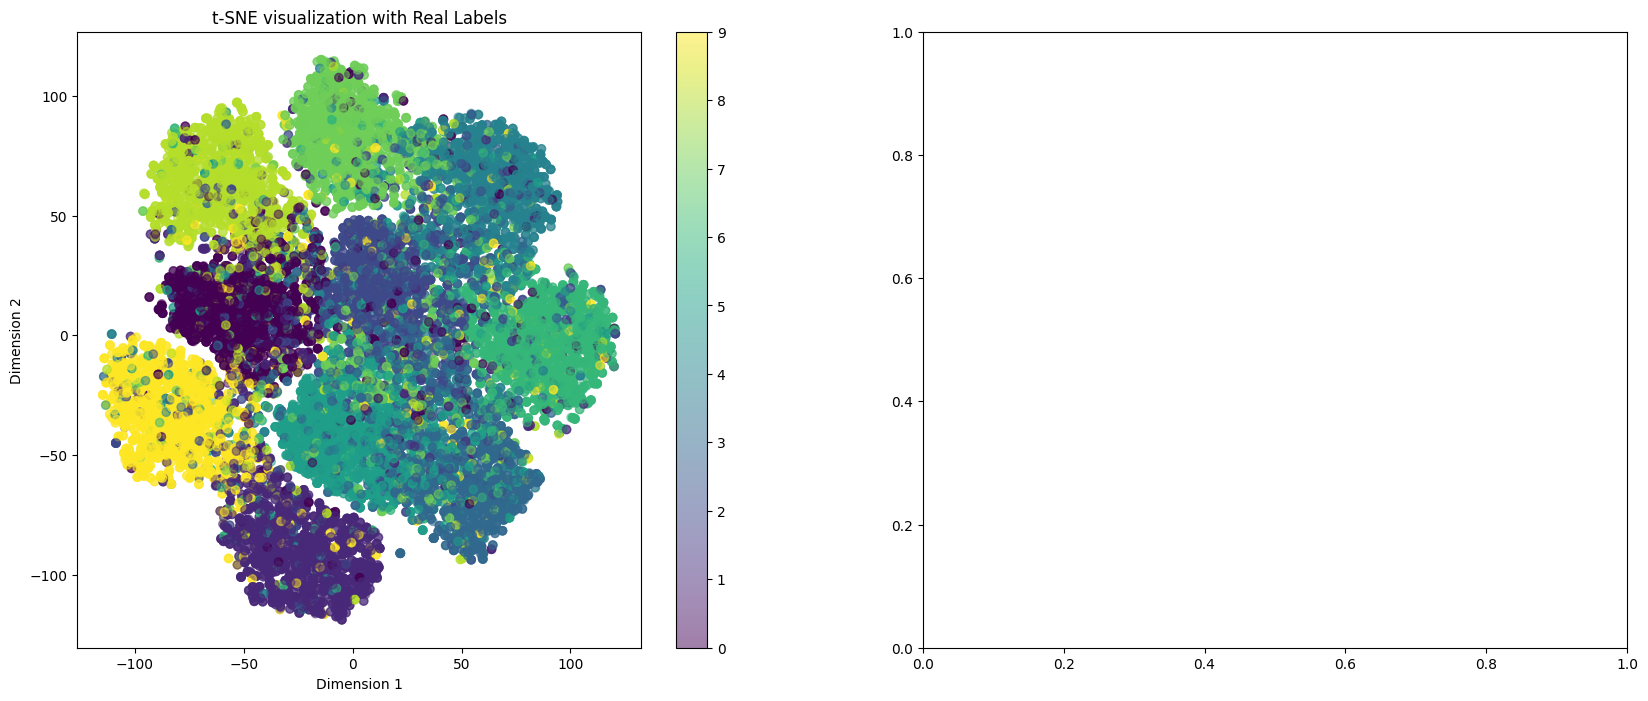

In [11]:
model = SiameseNetwork(10, 'resnet18')
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
contrastive_criterion = ContrastiveLoss()
device = torch.device('cuda')
model = model.to(device)

trainer = Trainer(model, contrastive_criterion, criterion, optimizer, cleaned_train_loader, device)
trainer.train(40)

visualizer = EmbeddingVisualizer(model, test_loader, device)
embeddings, real_labels, predicted_labels, indices, incorrect_images = visualizer.extract_embeddings()
visualizer.visualize(embeddings, real_labels, predicted_labels)


In [17]:

tester = Tester(model, train_loader, device)
tester.test()

Testing: 100%|██████████| 25/25 [00:54<00:00,  2.17s/it]

Test Accuracy: 81.30%
Test Precision: 0.81
Test Recall: 0.81
Test F1 Score: 0.81


(0.813, 0.8135891348733721, 0.813, 0.8130801537145111)

In [6]:
test_dataset_pair = DatasetPairs(test_dataset, num_pairs_per_epoch=25000)
test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)
wrong_preds = noise_detector.evaluate_noisy_samples(test_loader)

Evaluating Noisy Samples for fold 10: 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


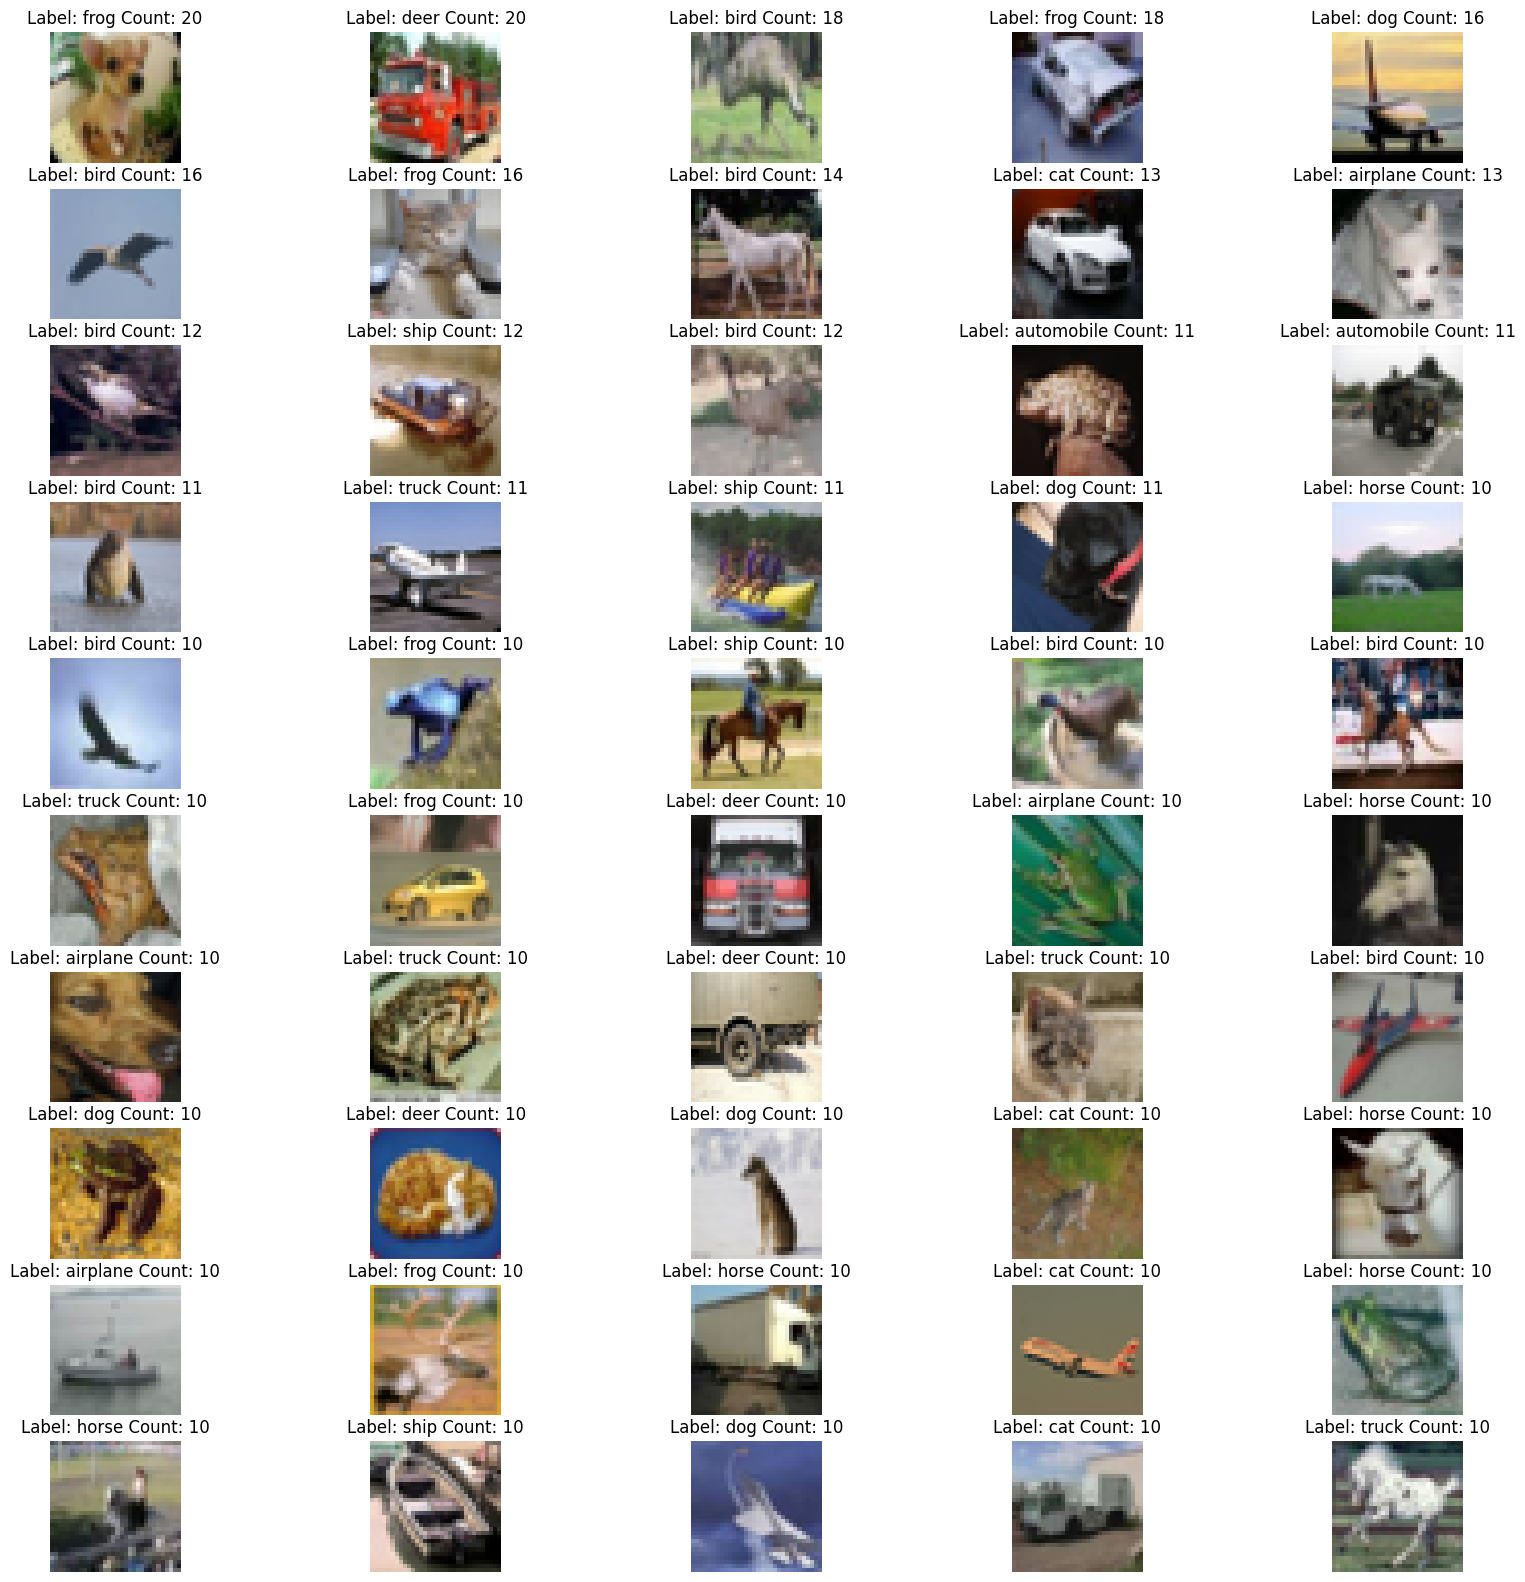

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


sorted_wrong_predictions = sorted(wrong_preds.items(), key=lambda item: item[1], reverse=True)

transform1 = transforms.ToTensor()
transform2 = transforms.ToPILImage()
sorted_indoces = []
plt.figure(figsize=(20, 20))
for i, (idx, count) in enumerate(sorted_wrong_predictions[:50]):
    sorted_indoces.append(idx)
    img, label = test_dataset[idx]
    img = transform2(transform1(img))
    plt.subplot(10, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {class_names[label]} Count: {count}")
    plt.axis('off')
plt.show()


In [9]:
real_noises = test_noise_adder.get_noisy_indices()

s = [idx for (idx, count) in wrong_preds.items() if count >= 10]
counts = [count for (idx, count) in wrong_preds.items()]

acc = test_noise_adder.calculate_noised_label_percentage(s)

81.66160081053698% accuracy in 987 data


(array([1973., 1062.,  765.,  583., 1247.,    9.,    3.,    3.,    2.,
           2.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

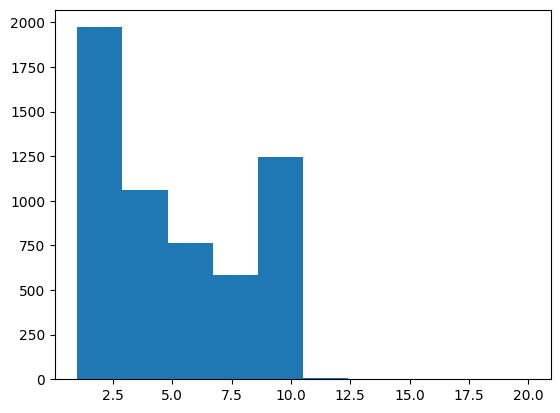

In [10]:
plt.hist(counts)

## CIFAR 100

In [11]:
train_dataset = CIFAR100(root='data', train=True, download=False)
test_dataset = CIFAR100(root='data', train=False, download=False)

train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=100)
train_noise_adder.add_noise()

test_noise_adder = LabelNoiseAdder(test_dataset, noise_level=0.1, num_classes=100)
test_noise_adder.add_noise()

In [12]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

: 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_detector = NoiseDetector(SiameseNetwork, train_dataset, device, num_classes=100, model_save_path="cifar100/resnet50/model_resnet50_cifar100_fold_{}.pth", batch_size=245, model='resnet50')
noise_detector.train_models(num_epochs=50)

Training fold 1/10...


Epoch 1/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, loss=4.52]


Epoch 1/50, Loss: 6.396632807595389


Epoch 2/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, loss=4.52]


Epoch 2/50, Loss: 4.538780280521938


Epoch 3/50: 100%|██████████| 49/49 [00:47<00:00,  1.02it/s, loss=4.58]


Epoch 3/50, Loss: 4.541986416797249


Epoch 4/50: 100%|██████████| 49/49 [00:47<00:00,  1.02it/s, loss=4.54]


Epoch 4/50, Loss: 4.5469730240958075


Epoch 5/50: 100%|██████████| 49/49 [00:48<00:00,  1.02it/s, loss=4.49]


Epoch 5/50, Loss: 4.542936519700653


Epoch 6/50: 100%|██████████| 49/49 [00:47<00:00,  1.02it/s, loss=4.55]


Epoch 6/50, Loss: 4.536799411384427


Epoch 7/50: 100%|██████████| 49/49 [00:48<00:00,  1.01it/s, loss=4.55]


Epoch 7/50, Loss: 4.534787246159145


Epoch 8/50: 100%|██████████| 49/49 [00:48<00:00,  1.02it/s, loss=4.51]


Epoch 8/50, Loss: 4.539447618990528


Epoch 9/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, loss=4.53]


Epoch 9/50, Loss: 4.52648571559361


Epoch 10/50: 100%|██████████| 49/49 [00:48<00:00,  1.02it/s, loss=4.55]


Epoch 10/50, Loss: 4.52428489801835


Epoch 11/50:  98%|█████████▊| 48/49 [00:46<00:00,  1.03it/s, loss=4.53]